In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MetaNet

/content/drive/MyDrive/MetaNet


In [ ]:
import jax
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

import numpy as np
import torch
import jax.numpy as jnp
from jax import random
import flax
from flax import linen as nn
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm.notebook import tqdm
from functools import partial
import time
import optax
import pickle
from functools import partial
from IPython.display import clear_output
import time
import os
import datetime
import math

gpu


In [ ]:
from jax.lib import xla_bridge
print(xla_bridge.get_backend().platform)

gpu


In [ ]:
# PARAMETERS

batch_size = 10
test_size = 100
meta_epochs_per_sine = 100
num_train_sines = 1000
num_test_sines = 10000
num_epochs = 50
lr = 0.1
alpha = 1e-2
beta = 1e-3

In [ ]:
# Define model
class SineModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        hidden_1 = nn.tanh(nn.Dense(12)(x))
        hidden_2 = nn.tanh(nn.Dense(8)(hidden_1))
        output = nn.Dense(1)(hidden_2)

        return output

model = SineModel()

class MetaNet(nn.Module):
    num_params: int = 137

    @nn.compact
    def __call__(self, carry, inputs):
        lstm_cell = nn.LSTMCell(features=self.num_params, name='lstm_cell')
        new_carry, lstm_output = lstm_cell(carry, inputs)

        concatenated_output = jnp.concatenate([lstm_output, inputs[-self.num_params:]], axis=0)

        dense_output = nn.Dense(features=self.num_params, name='dense_output')(concatenated_output)

        return new_carry, dense_output

    def get_initial_carry(self):
      return (jnp.zeros((self.num_params,)), jnp.zeros((self.num_params,)))

meta_net = MetaNet()

class LargeSineModel(nn.Module):
    @nn.compact
    def __call__(self, x):
        hidden_1 = nn.tanh(nn.Dense(600)(x))
        hidden_2 = nn.tanh(nn.Dense(500)(hidden_1))
        output = nn.Dense(1)(hidden_2)

        return output

large_model = LargeSineModel()

In [ ]:
class Sine:
  def __init__(self, a=None, b=None, amp_range=[0.1,5.0], phase_shift_range=[0,np.pi], input_range=[0.0, 10.0]):
    if a is None:
      self.a = np.random.uniform(*amp_range)
    else: self.a = a
    if b is None:
      self.b = np.random.uniform(*phase_shift_range)
    else: self.b = b
    self.input_range = input_range

  def __call__(self, x):
    return jnp.array(self.a*np.sin(x + self.b))

  def batch(self, n=batch_size):
    x = np.random.uniform(self.input_range[0], self.input_range[1], [n, 1])
    # x = np.expand_dims(np.linspace(self.input_range[0], self.input_range[1], n), -1)
    y = self(x)
    return jnp.array(x), jnp.array(y)

  def test_set(self, n=test_size):
    x = np.expand_dims(np.linspace(self.input_range[0], self.input_range[1], n), -1)
    y = self(x)

    return jnp.array(x), jnp.array(y)

  def __str__(self):
    return f"y={self.a}sin(x + {self.b})"

  def plot(self, n=test_size):
    x, y = self.test_set(n=n)
    return plt.plot(x[:,0], y[:,0])

In [ ]:
key = random.PRNGKey(86)

def use_key():
  """
  create new key value (using jax.random.split) and return old key value
  """

  global key

  old_key = key
  key = random.split(key, num=1)[0]
  return old_key

def make_keys(n):
  global key

  keys = random.split(key, num=int(n))
  key = keys[-1]
  keys = keys[:-1]

  return keys

def init_params(input_size=(1,)):
  """
  randomly initialize parameters for model
  """

  global model, key

  dummy_input = random.normal(use_key(), input_size)
  params = model.init(use_key(), dummy_input)

  return params

def init_large_params(input_size=(1,)):
  """
  randomly initialize parameters for model
  """

  global large_model, key

  dummy_input = random.normal(use_key(), input_size)
  large_params = large_model.init(use_key(), dummy_input)

  return large_params

def init_meta_params(input_shape=(274,)):
  global meta_net, key

  dummy_input = jax.random.normal(use_key(), input_shape)
  carry0 = meta_net.get_initial_carry()
  meta_params0 = meta_net.init(use_key(), carry0, dummy_input)

  return meta_params0, carry0

In [ ]:
import jax.numpy as jnp

def init_custom_meta_params(lstm_hidden_dim=137, input_shape=(274,)):
    """
    Initialize meta parameters to achieve specific behavior for the LSTM and the subsequent dense layer.

    Args:
    - lstm_hidden_dim: Dimensionality of the LSTM hidden state.
    - input_shape: The shape of the input to the MetaNet, expected to be (274,).

    Returns:
    - Custom initialized meta parameters dictionary.
    """
    # LSTM initialization: might be minimal as its output is not the primary focus for initialization
    lstm_params = {
        'hf': {'bias': jnp.zeros(lstm_hidden_dim), 'kernel': jnp.zeros((lstm_hidden_dim, lstm_hidden_dim))},
        'hg': {'bias': jnp.zeros(lstm_hidden_dim), 'kernel': jnp.zeros((lstm_hidden_dim, lstm_hidden_dim))},
        'hi': {'bias': jnp.zeros(lstm_hidden_dim), 'kernel': jnp.zeros((lstm_hidden_dim, lstm_hidden_dim))},
        'ho': {'bias': jnp.zeros(lstm_hidden_dim), 'kernel': jnp.zeros((lstm_hidden_dim, lstm_hidden_dim))},
        'if': {'kernel': jnp.zeros((input_shape[0], lstm_hidden_dim))},
        'ig': {'kernel': jnp.zeros((input_shape[0], lstm_hidden_dim))},
        'ii': {'kernel': jnp.zeros((input_shape[0], lstm_hidden_dim))},
        'io': {'kernel': jnp.zeros((input_shape[0], lstm_hidden_dim))}
    }

    # Dense layer initialization: the kernel selects the gradients from its input
    identity_matrix = jnp.eye(lstm_hidden_dim)  # For selecting gradients
    zeros_matrix = jnp.zeros((lstm_hidden_dim, lstm_hidden_dim))  # For ignoring LSTM output
    dense_kernel = jnp.concatenate([zeros_matrix, identity_matrix], axis=0)  # Combine for the dense layer kernel
    dense_bias = jnp.zeros(lstm_hidden_dim)  # Bias is initialized to zero

    dense_params = {
        'dense_output': {'bias': dense_bias, 'kernel': dense_kernel}
    }

    # Combine LSTM and Dense parameters under 'params'
    meta_params = {
        'params': {
            'lstm_cell': lstm_params,
            **dense_params
        }
    }

    return meta_params, dense_kernel

In [ ]:
meta_exp_save = pickle.load(open('metanet_experiment_03-13_08-12-2024/save_data_03-13_08-12-2024.pkl', 'rb'))
maml_exp_save = pickle.load(open('maml_experiment_03-13_18-03-2024/save_data_03-13_18-03-2024.pkl', 'rb'))

In [ ]:
meta_params = meta_exp_save['meta_params']
carry0 = meta_exp_save['carry0']
large_params0 = meta_exp_save['large_params0']
params0 = meta_exp_save['params0']

meta_maml_params = maml_exp_save['meta_params']
maml_carry0 = maml_exp_save['carry0']
trans_params = maml_exp_save['trans_params']
maml_params = maml_exp_save['maml_params']

a_vals = meta_exp_save['testing']['a_vals']
b_vals = meta_exp_save['testing']['b_vals']
sines_matrix = meta_exp_save['testing']['sines_matrix']
test_calibration_data = meta_exp_save['testing']['test_calibration_data']

In [ ]:
@jax.jit
def mse(params, x_batched, y_batched):
  def squared_error(x, y):
    pred = model.apply(params, x)
    return jnp.inner(y-pred, y-pred) / 2.0
  return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)

mse_grad = jax.jit(jax.value_and_grad(mse))

@jax.jit
def update_params(params, learning_rate, grads):
  params = jax.tree_util.tree_map(
      lambda p, g: p - learning_rate * g, params, grads)
  return params

@jax.jit
def gradient_descent_step(params, x_batched, y_batched, learning_rate):
  loss, grads = mse_grad(params, x_batched, y_batched)
  params = update_params(params, learning_rate, grads)
  return params, loss

@jax.jit
def gradient_descent_step_with_grads(params, x_batched, y_batched, learning_rate):
  loss, grads = mse_grad(params, x_batched, y_batched)
  params = update_params(params, learning_rate, grads)
  return params, loss, grads

@partial(jax.jit, static_argnames=['tx'])
def adam_step(params, tx, opt_state, x_batched, y_batched):
  loss, grads = mse_grad(params, x_batched, y_batched)
  updates, opt_state = tx.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return params, opt_state, loss

@jax.jit
def maml_mse(params, x, y, X, Y, alpha=alpha):
  params, _ = gradient_descent_step(params, x, y, alpha)
  return mse(params, X, Y)

maml_mse_grad = jax.value_and_grad(maml_mse)

@partial(jax.jit, static_argnames=['tx'])
def maml_step(params, tx, opt_state, x, y, X, Y, alpha=alpha, beta=beta):
  loss_outer, grads = maml_mse_grad(params, x, y, X, Y, alpha=alpha)
  updates, opt_state = tx.update(grads, opt_state)
  params = optax.apply_updates(params, updates)
  return params, loss_outer, opt_state, grads

@partial(jax.jit, static_argnames=['num_epochs'])
def get_loss_curve(params0, x, y, X, Y, alpha=alpha, num_epochs=num_epochs):
  params = deepcopy(params0)
  loss_curve = []
  for i in range(num_epochs):
    params, _ = gradient_descent_step(params, x, y, alpha)
    loss_curve.append(mse(params, X, Y))
  return loss_curve, params

In [ ]:
@jax.jit
def large_mse(params, x_batched, y_batched):
  def squared_error(x, y):
    pred = large_model.apply(params, x)
    return jnp.inner(y-pred, y-pred) / 2.0
  return jnp.mean(jax.vmap(squared_error)(x_batched,y_batched), axis=0)

large_mse_grad = jax.jit(jax.value_and_grad(large_mse))

@jax.jit
def large_gradient_descent_step_with_grads(params, x_batched, y_batched, learning_rate):
  loss, grads = large_mse_grad(params, x_batched, y_batched)
  params = update_params(params, learning_rate, grads)
  return params, loss, grads

In [ ]:
@jax.jit
def concat_params_grads(params, grads):
  param_vals = jnp.concatenate(list(map(lambda x: x.flatten(), jax.tree_util.tree_leaves(params))))
  grad_vals = jnp.concatenate(list(map(lambda x: x.flatten(), jax.tree_util.tree_leaves(grads))))
  return jnp.concatenate([jnp.array(param_vals), jnp.array(grad_vals)])

@jax.jit
def flatten_pytree(pytree):
  return jnp.concatenate(list(map(lambda x: x.flatten(), jax.tree_util.tree_leaves(pytree))))

@jax.jit
def array_to_pytree(flat_array):
    # Indices to split the flat array
    dense_0_kernel_end = 12
    dense_0_bias_end = dense_0_kernel_end + 12
    dense_1_kernel_end = dense_0_bias_end + 96
    dense_1_bias_end = dense_1_kernel_end + 8
    dense_2_kernel_end = dense_1_bias_end + 8
    # Reshaping
    dense_0_kernel = flat_array[:dense_0_kernel_end].reshape(1, 12)
    dense_0_bias = flat_array[dense_0_kernel_end:dense_0_bias_end]
    dense_1_kernel = flat_array[dense_0_bias_end:dense_1_kernel_end].reshape(12, 8)
    dense_1_bias = flat_array[dense_1_kernel_end:dense_1_bias_end]
    dense_2_kernel = flat_array[dense_1_bias_end:dense_2_kernel_end].reshape(8, 1)
    dense_2_bias = flat_array[dense_2_kernel_end:].reshape(1,)
    # Constructing the pytree
    pytree = {
        'params': {
            'Dense_0': {'kernel': dense_0_kernel, 'bias': dense_0_bias},
            'Dense_1': {'kernel': dense_1_kernel, 'bias': dense_1_bias},
            'Dense_2': {'kernel': dense_2_kernel, 'bias': dense_2_bias},
        }
    }
    return pytree

@jax.jit
def meta_step(params, meta_params, carry, x, y, lr=lr):
  loss, grads = mse_grad(params, x, y)
  new_carry, opt_grads = meta_net.apply(meta_params, carry, concat_params_grads(params, grads))
  opt_grads_tree = array_to_pytree(opt_grads)
  params = jax.tree_util.tree_map(lambda p, g: p - lr * g, params, opt_grads_tree)
  return params, new_carry

@jax.jit
def meta_loss(meta_params, params, carry, x, y, X, Y, lr=lr):
  params_star, new_carry = meta_step(params, meta_params, carry, x, y, lr)
  return mse(params_star, X, Y), {"params": params_star, "carry": new_carry}

@partial(jax.jit, static_argnames=['num_epochs'])
def meta_loss_curve(params, meta_params, carry, x, y, X, Y, lr=lr, num_epochs=num_epochs):
  loss_curve = []
  for i in range(num_epochs):
    params, carry = meta_step(params, meta_params, carry, x, y, lr)
    loss_curve.append(mse(params, X, Y))
  return loss_curve

meta_grad = jax.jit(jax.value_and_grad(meta_loss, has_aux=True))

@jax.jit
def clip_tree(tree, min_val=-100.0, max_val=100.0):
    """
    Clips all elements of the input PyTree to be within the range [min_val, max_val].

    Args:
        tree: Input PyTree.
        min_val: Minimum value for clipping.
        max_val: Maximum value for clipping.

    Returns:
        Clipped PyTree.
    """
    if isinstance(tree, (list, tuple)):
        return [clip_tree(subtree, min_val, max_val) for subtree in tree]
    elif isinstance(tree, dict):
        return {key: clip_tree(subtree, min_val, max_val) for key, subtree in tree.items()}
    else:
        return jax.numpy.clip(tree, min_val, max_val)

@partial(jax.jit, static_argnames=['num_epochs'])
def update_meta_net(params, meta_params, carry0, x, y, X, Y, lr=lr, meta_lr=0.1, num_epochs=num_epochs, clip_min=-10.0, clip_max=10.0):
  meta_grads_accumulated = None
  carry = carry0

  weights = jnp.linspace(1, num_epochs, num_epochs)
  total_weight = weights.sum()

  for epoch in range(num_epochs):
    (meta_losses, meta_cache), meta_grads = meta_grad(meta_params, params, carry, x, y, X, Y, lr)
    if clip_min is not None and clip_max is not None:
      meta_grads = clip_tree(meta_grads, min_val=clip_min, max_val=clip_max)

    if meta_grads_accumulated is None:
        meta_grads_accumulated = jax.tree_util.tree_map(lambda g: g * weights[epoch], meta_grads)
    else:
        meta_grads_accumulated = jax.tree_util.tree_map(lambda acc, g: acc + g * weights[epoch], meta_grads_accumulated, meta_grads)

    params = meta_cache["params"]
    carry = meta_cache["carry"]

  meta_grads_weighted_average = jax.tree_util.tree_map(lambda acc: acc / total_weight, meta_grads_accumulated)
  meta_params = jax.tree_util.tree_map(lambda p, g: p - meta_lr * g, meta_params, meta_grads_weighted_average)

  return meta_params, meta_loss_curve(params0, meta_params, carry0, x, y, X, Y, lr=lr, num_epochs=num_epochs), meta_grads_weighted_average

@partial(jax.jit, static_argnames=['num_epochs'])
def jit_calibrate_params(params, meta_params, carry0, x, y, test_data=None, lr=lr, num_epochs=num_epochs):
  carry = carry0
  test_loss_curve = None

  for epoch in range(num_epochs):
    params, carry = meta_step(params, meta_params, carry, x, y, lr)
    if test_data is not None:
      if test_loss_curve is None:
        test_loss_curve = []
      test_loss_curve.append(mse(params, *test_data))

  return params, test_loss_curve

def calibrate_params(params, meta_params, carry0, x, y, test_data=None, lr=lr, num_epochs=num_epochs):
  carry = carry0
  test_loss_curve = None

  for epoch in range(num_epochs):
    params, carry = meta_step(params, meta_params, carry, x, y, lr)
    if test_data is not None:
      if test_loss_curve is None:
        test_loss_curve = []
      test_loss_curve.append(mse(params, *test_data))

  return params, test_loss_curve

@partial(jax.jit, static_argnames=['num_epochs'])
def gradient_descent_loop(params0, x, y, X, Y, lr=lr, num_epochs=num_epochs):
  params = deepcopy(params0)
  loss_curve = []

  for i in range(num_epochs):
    params, loss_value, _ = gradient_descent_step_with_grads(params, x, y, lr)
    loss_curve.append(loss_value)

  return params, loss_curve

In [ ]:
# Use for gradient descent, transfer learning, and maml
@jax.jit
def get_gd_loss(x, y, X, Y, lr, params0=params0):
  params = deepcopy(params0)
  for i in range(num_epochs):
    params, _, _ = gradient_descent_step_with_grads(params, x, y, lr)

  mse_loss = mse(params, X, Y)
  return mse_loss, params

# Use for metanet and metanet+maml
@jax.jit
def get_meta_loss(meta_params, carry, x, y, X, Y, lr, params0=params0):
  params = deepcopy(params0)
  carry = deepcopy(carry)
  params, _ = calibrate_params(params, meta_params, carry, x, y, test_data=None, lr=lr, num_epochs=num_epochs)
  mse_loss = mse(params, X, Y)
  return mse_loss, params

# Use for gradient descent (large model)
@jax.jit
def get_large_gd_loss(x, y, X, Y, lr, params0=large_params0):
  params = deepcopy(params0)
  for i in range(num_epochs):
    params, _, _ = large_gradient_descent_step_with_grads(params, x, y, lr)

  mse_loss = large_mse(params, X, Y)
  return mse_loss, params

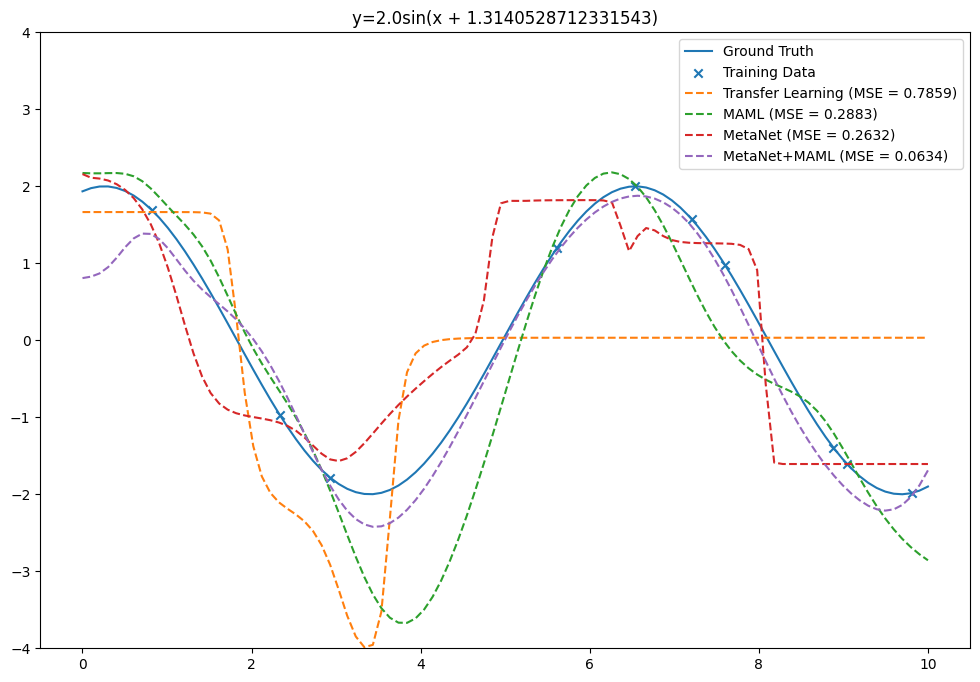

In [ ]:
sine_test = Sine(a=2.0)
X_test, Y_test = sine_test.test_set()
x_test, y_test = sine_test.batch()

model_infos = {
    # "Gradient Descent (Large Model)": {
    #     "loss_fn": partial(get_large_gd_loss, x_test, y_test, X_test, Y_test, 0.01, params0=large_params0),
    #     "predict_fn": large_model.apply,
    # },
    "Transfer Learning": {
        "loss_fn": partial(get_gd_loss, x_test, y_test, X_test, Y_test, lr, params0=trans_params),
        "predict_fn": model.apply,
    },
    "MAML": {
        "loss_fn": partial(get_gd_loss, x_test, y_test, X_test, Y_test, alpha, params0=maml_params),
        "predict_fn": model.apply,
    },
    "MetaNet": {
        "loss_fn": partial(get_meta_loss, meta_params, carry0, x_test, y_test, X_test, Y_test, lr, params0=params0),
        "predict_fn": model.apply,
    },
    "MetaNet+MAML": {
        "loss_fn": partial(get_meta_loss, meta_maml_params, maml_carry0, x_test, y_test, X_test, Y_test, alpha, params0=maml_params),
        "predict_fn": model.apply,
    },
}

plt.figure(figsize=(12, 8))
plt.plot(X_test, Y_test, label='Ground Truth')
plt.scatter(x_test, y_test, marker='x', label='Training Data')
plt.title(f"{str(sine_test)}")

for model_name, model_info in model_infos.items():
  mse_value, fitted_params = model_info["loss_fn"]()
  model_preds = model_info["predict_fn"](fitted_params, X_test)

  plt.plot(X_test, model_preds, label=f"{model_name} (MSE = {mse_value:.4f})", linestyle='--')

plt.legend()
plt.ylim(-sine_test.a*2, sine_test.a*2)
plt.show()

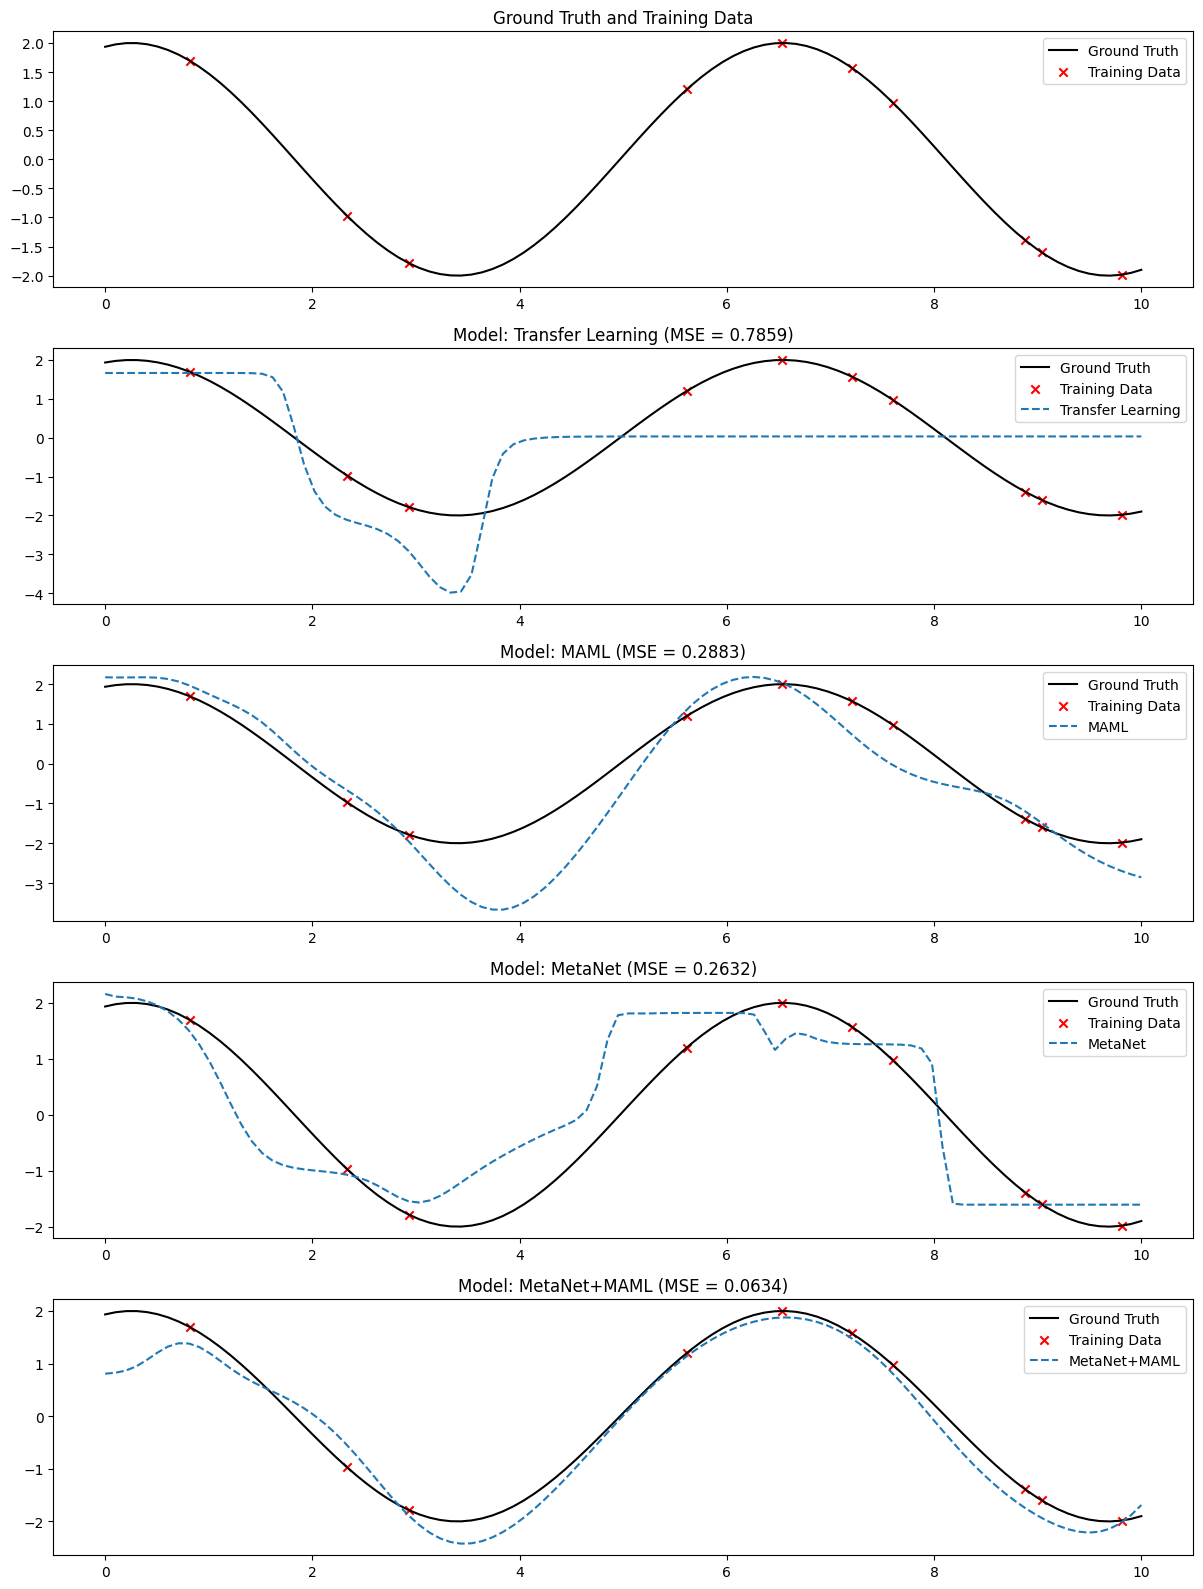

In [ ]:
num_models = len(model_infos)

# Set up a figure for subplots. Adjust figsize to make sure it's large enough
plt.figure(figsize=(12, num_models * 4))  # Height is adjusted based on the number of models

# Plot ground truth and training data once at the top
plt.subplot(num_models + 1, 1, 1)  # +1 for the ground truth and training data plot
plt.plot(X_test, Y_test, label='Ground Truth', color='black')
plt.scatter(x_test, y_test, marker='x', label='Training Data', color='red')
plt.title("Ground Truth and Training Data")
plt.legend()

# Iterate over models to create a subplot for each
for idx, (model_name, model_info) in enumerate(model_infos.items(), start=2):  # Start from 2 since the first plot is already used
    mse_value, fitted_params = model_info["loss_fn"]()
    model_preds = model_info["predict_fn"](fitted_params, X_test)

    plt.subplot(num_models + 1, 1, idx)
    plt.plot(X_test, Y_test, label='Ground Truth', color='black')
    plt.scatter(x_test, y_test, marker='x', label='Training Data', color='red')
    plt.plot(X_test, model_preds, label=f"{model_name}", linestyle='--')
    plt.title(f"Model: {model_name} (MSE = {mse_value:.4f})")
    plt.legend()

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

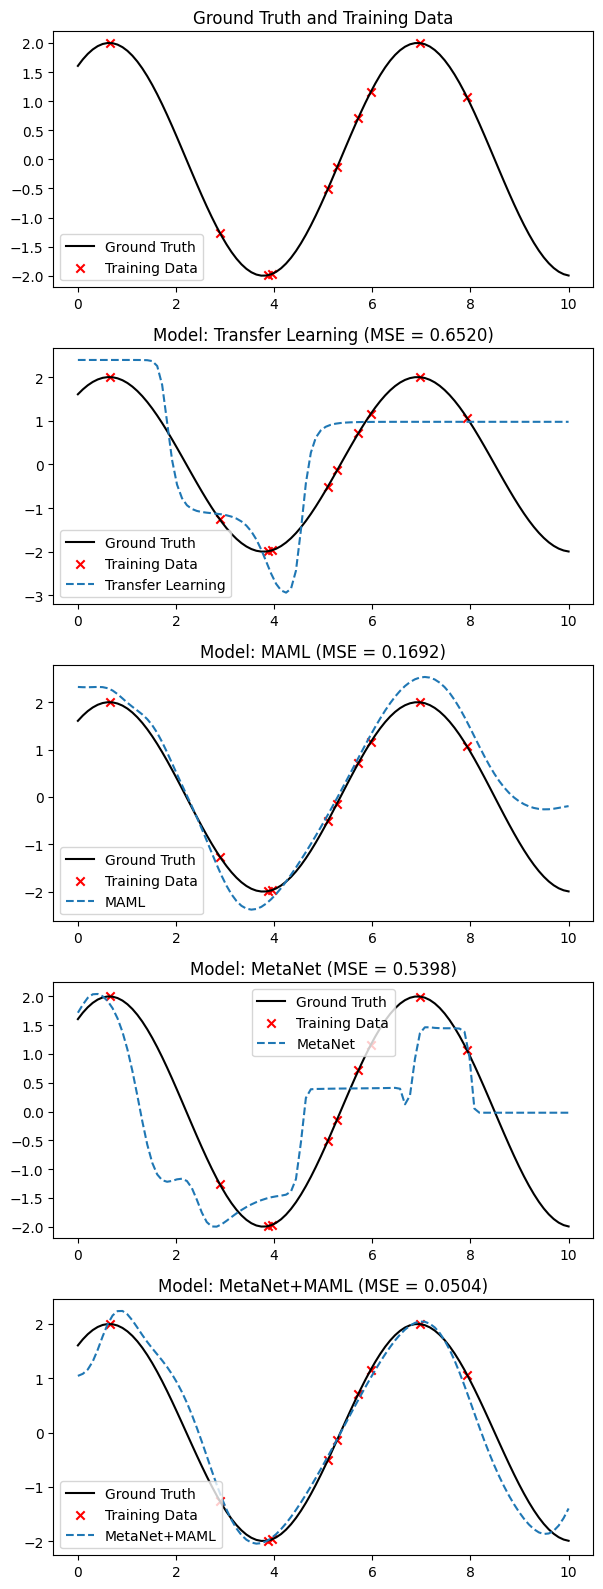

In [ ]:
num_models = len(model_infos)

# Set up a figure for subplots. Adjust figsize to make sure it's large enough
plt.figure(figsize=(6, num_models * 4))  # Height is adjusted based on the number of models

# Plot ground truth and training data once at the top
plt.subplot(num_models + 1, 1, 1)  # +1 for the ground truth and training data plot
plt.plot(X_test, Y_test, label='Ground Truth', color='black')
plt.scatter(x_test, y_test, marker='x', label='Training Data', color='red')
plt.title("Ground Truth and Training Data")
plt.legend()

# Iterate over models to create a subplot for each
for idx, (model_name, model_info) in enumerate(model_infos.items(), start=2):  # Start from 2 since the first plot is already used
    mse_value, fitted_params = model_info["loss_fn"]()
    model_preds = model_info["predict_fn"](fitted_params, X_test)

    plt.subplot(num_models + 1, 1, idx)
    plt.plot(X_test, Y_test, label='Ground Truth', color='black')
    plt.scatter(x_test, y_test, marker='x', label='Training Data', color='red')
    plt.plot(X_test, model_preds, label=f"{model_name}", linestyle='--')
    plt.title(f"Model: {model_name} (MSE = {mse_value:.4f})")
    plt.legend()

plt.tight_layout()  # Adjust layout to make sure everything fits without overlapping
plt.show()

In [ ]:
# Use for gradient descent, transfer learning, and maml
def get_gd_loss_matrix(sines_matrix, test_calibration_data, lr, params0=params0):
  matrix = np.array([[[None, None] for i in range(100)] for i in range(100)])
  for i in range(100):
    for j in range(100):
      X, Y = sines_matrix[i][j].test_set()
      x, y = test_calibration_data[i][j]
      mse_value, _ = get_gd_loss(x, y, X, Y, lr, params0=params0)
      mse_value = mse_value.item()
      matrix[i][j][0] = mse_value
      matrix[i][j][1] = mse_value / (sines_matrix[i][j].a ** 2)
  return matrix

# Use for metanet and metanet+maml
def get_meta_loss_matrix(sines_matrix, test_calibration_data, meta_params, carry, lr, params0=params0):
  matrix = np.array([[[None, None] for i in range(100)] for i in range(100)])
  for i in range(100):
    for j in range(100):
      X, Y = sines_matrix[i][j].test_set()
      x, y = test_calibration_data[i][j]
      mse_value, _ = get_meta_loss(meta_params, carry, x, y, X, Y, lr, params0=params0)
      mse_value = mse_value.item()
      matrix[i][j][0] = mse_value
      matrix[i][j][1] = mse_value / (sines_matrix[i][j].a ** 2)
  return matrix

# Use for gradient descent (large model)
def get_large_gd_loss_matrix(sines_matrix, test_calibration_data, lr, params0=large_params0):
  matrix = np.array([[[None, None] for i in range(100)] for i in range(100)])
  for i in range(100):
    for j in range(100):
      X, Y = sines_matrix[i][j].test_set()
      x, y = test_calibration_data[i][j]
      mse_value, _ = get_large_gd_loss(x, y, X, Y, lr, params0=large_params0)
      mse_value = mse_value.item()
      matrix[i][j][0] = mse_value
      matrix[i][j][1] = mse_value / (sines_matrix[i][j].a ** 2)
  return matrix

In [ ]:
large_matrix = get_large_gd_loss_matrix(sines_matrix, test_calibration_data, 0.001, params0=large_params0)
trans_matrix = get_gd_loss_matrix(sines_matrix, test_calibration_data, lr, params0=trans_params)
maml_matrix = get_gd_loss_matrix(sines_matrix, test_calibration_data, alpha, params0=maml_params)
meta_matrix = get_meta_loss_matrix(sines_matrix, test_calibration_data, meta_params, carry0, lr, params0=params0)
meta_maml_matrix = get_meta_loss_matrix(sines_matrix, test_calibration_data, meta_maml_params, maml_carry0, alpha, params0=maml_params)

large_matrix = np.array(large_matrix).astype(np.float64)
trans_matrix = np.array(trans_matrix).astype(np.float64)
maml_matrix = np.array(maml_matrix).astype(np.float64)
meta_matrix = np.array(meta_matrix).astype(np.float64)
meta_maml_matrix = np.array(meta_maml_matrix).astype(np.float64)

In [ ]:
large_matrix[:, :, -1].max()

0.5532689931348334

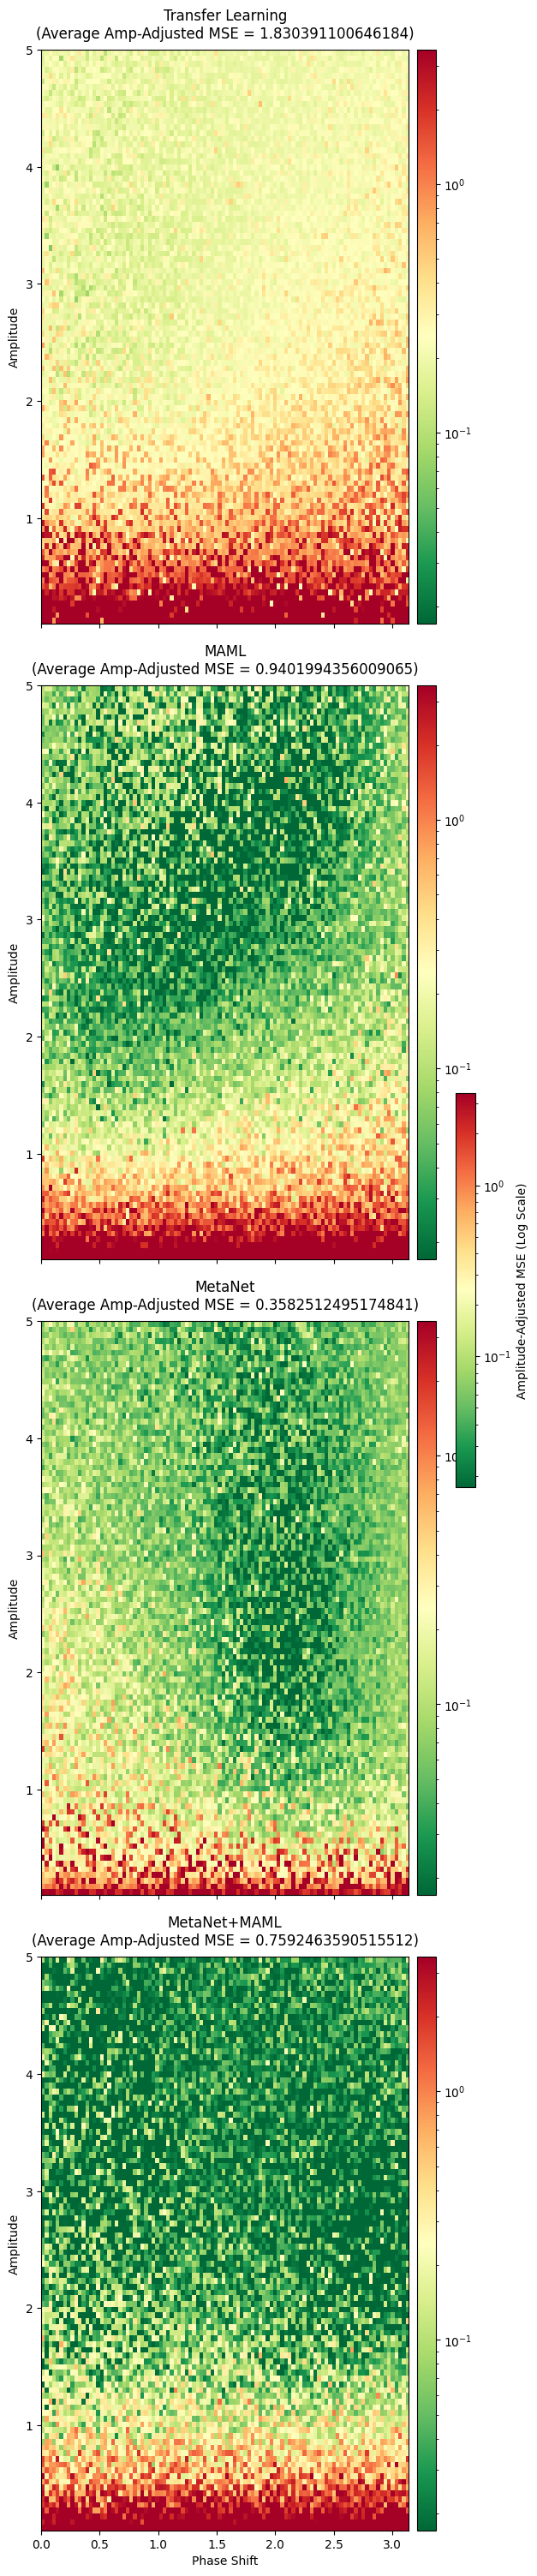

In [ ]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

loss_matrices = {
    # "Gradient Descent (Large Model)": large_matrix,
    "Transfer Learning": trans_matrix,
    "MAML": maml_matrix,
    "MetaNet": meta_matrix,
    "MetaNet+MAML": meta_maml_matrix,
}

loss_matrices_keys = list(loss_matrices.keys())

all_values = np.concatenate([matrix.flatten() for matrix in loss_matrices.values()])
vmin, vmax = np.percentile(all_values, [5, 95])
log_norm = LogNorm(vmin=vmin, vmax=vmax)

fig, axs = plt.subplots(4, 1, figsize=(6, 30), constrained_layout=True)

for i, (ax, loss_matrix_key) in enumerate(zip(axs, loss_matrices_keys)):
    pcm = ax.imshow(loss_matrices[loss_matrix_key][:, :, -1], aspect='equal', origin='lower',
                    norm=log_norm, cmap='RdYlGn_r',
                    extent=[b_vals.min(), b_vals.max(), a_vals.min(), a_vals.max()])
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Phase Shift')
    ax.set_ylim([a_vals.min(), a_vals.max()])
    ax.set_title(f'{loss_matrix_key}\n(Average Amp-Adjusted MSE = {loss_matrices[loss_matrix_key][:, :, -1].mean()})', pad=10)  # Set title for each subplot
    ax.label_outer()  # Hide labels that are not at the edge
    # Add a colorbar to the right of each subplot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    fig.colorbar(pcm, cax=cax, orientation='vertical')

    ax.label_outer()  # Hide labels that are not at the edge

# Add a colorbar to the figure
cbar = fig.colorbar(pcm, ax=axs, orientation='vertical', fraction=.05)
cbar.set_label('Amplitude-Adjusted MSE (Log Scale)')

# Show the plot
plt.show()

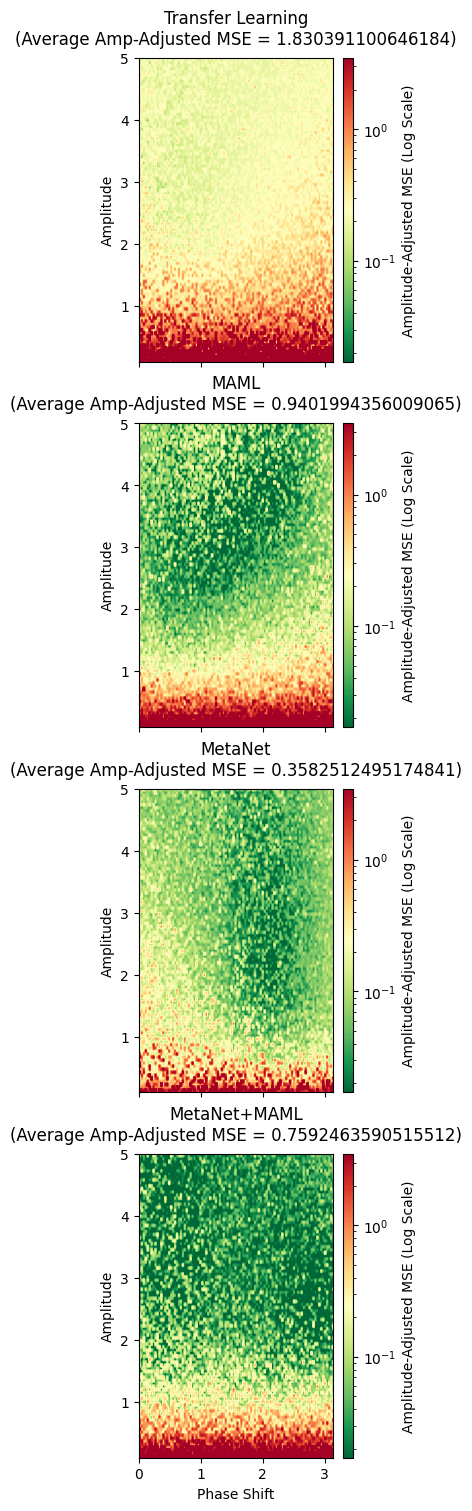

In [ ]:
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1 import make_axes_locatable

loss_matrices = {
    # "Gradient Descent (Large Model)": large_matrix,
    "Transfer Learning": trans_matrix,
    "MAML": maml_matrix,
    "MetaNet": meta_matrix,
    "MetaNet+MAML": meta_maml_matrix,
}

loss_matrices_keys = list(loss_matrices.keys())

all_values = np.concatenate([matrix.flatten() for matrix in loss_matrices.values()])
vmin, vmax = np.percentile(all_values, [5, 95])
log_norm = LogNorm(vmin=vmin, vmax=vmax)

fig, axs = plt.subplots(4, 1, figsize=(3, 15), constrained_layout=True)

for i, (ax, loss_matrix_key) in enumerate(zip(axs, loss_matrices_keys)):
    pcm = ax.imshow(loss_matrices[loss_matrix_key][:, :, -1], aspect='equal', origin='lower',
                    norm=log_norm, cmap='RdYlGn_r',
                    extent=[b_vals.min(), b_vals.max(), a_vals.min(), a_vals.max()])
    ax.set_ylabel('Amplitude')
    ax.set_xlabel('Phase Shift')
    ax.set_ylim([a_vals.min(), a_vals.max()])
    ax.set_title(f'{loss_matrix_key}\n(Average Amp-Adjusted MSE = {loss_matrices[loss_matrix_key][:, :, -1].mean()})', pad=10)  # Set title for each subplot
    ax.label_outer()  # Hide labels that are not at the edge
    # Add a colorbar to the right of each subplot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    cbar = fig.colorbar(pcm, cax=cax, orientation='vertical')
    cbar.set_label('Amplitude-Adjusted MSE (Log Scale)')

    ax.label_outer()  # Hide labels that are not at the edge

# Add a colorbar to the figure
# cbar = fig.colorbar(pcm, ax=axs, orientation='vertical', fraction=.05)
# cbar.set_label('Amplitude-Adjusted MSE (Log Scale)')

# Show the plot
plt.show()

In [ ]:
import pandas as pd

comp_matrix = {}

for loss_maetrix_key in loss_matrices_keys:
  comp_matrix[loss_matrix_key + "poop"] = {}
  for second_matrix_key in loss_matrices_keys:
    comp_matrix[loss_matrix_key + "poop"][second_matrix_key] = f"{100 * np.sum(loss_matrices[loss_matrix_key][:,:,-1] < loss_matrices[second_matrix_key][:,:,-1]) / 10000:.2f}"

comp_matrix = pd.DataFrame(comp_matrix)
display(comp_matrix)

,Transfer Learningpoop,MAMLpoop,MetaNetpoop,MetaNet+MAMLpoop
Transfer Learning,0.00,93.00,94.41,93.21
MAML,7.00,0.00,53.71,64.24
MetaNet,5.59,46.29,0.00,61.57
MetaNet+MAML,6.79,35.76,38.43,0.00


In [ ]:
current_datetime = datetime.datetime.now().strftime("%m-%d_%H-%M-%Y")

folder_name = f"testing_data_{current_datetime}"
os.makedirs(folder_name, exist_ok=True)  # This creates the folder if it doesn't already exist

to_save = {
    "large_matrix": large_matrix,
    "trans_matrix": trans_matrix,
    "maml_matrix": maml_matrix,
    "meta_matrix": meta_matrix,
    "meta_maml_matrix": meta_maml_matrix,
}

pickle_file_path = os.path.join(folder_name, f"test_save_data_{current_datetime}.pkl")
with open(pickle_file_path, "wb") as pickle_file:
    pickle.dump(to_save, pickle_file)

print(f"data has been saved successfully in {pickle_file_path}")

data has been saved successfully in testing_data_03-14_13-25-2024/test_save_data_03-14_13-25-2024.pkl
